# Setup

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 23.1 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import math

from tabulate import tabulate
from tqdm import trange
import random
from torchmetrics.classification import Recall, Accuracy, AUROC, Precision

In [4]:
df = pd.read_csv('/content/combined.csv')

dataset = df[['text', 'toxic']]
dataset.head()

,text,toxic
0,real faker tweet,0
1,Lmfao,0
2,"bruh, the best teemo player from my country is...",0
3,me and nunu tiered 3 simped for adc,0
4,yeah but i think since seraphine was released ...,0


In [5]:
import re
import string

# Remove punctuation, digits, and weird characters and convert words to lowercase
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", " ", text.lower())
    return text

# Preprocess text
dataset.loc[:, 'cleaned_text'] = dataset['text'].apply(preprocess_text)

<ipython-input-5-b17eac554e8a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[:, 'cleaned_text'] = dataset['text'].apply(preprocess_text)


In [6]:
text = dataset.cleaned_text.values
labels = dataset.toxic.values

<ipython-input-7-ae162889f13e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="viridis")


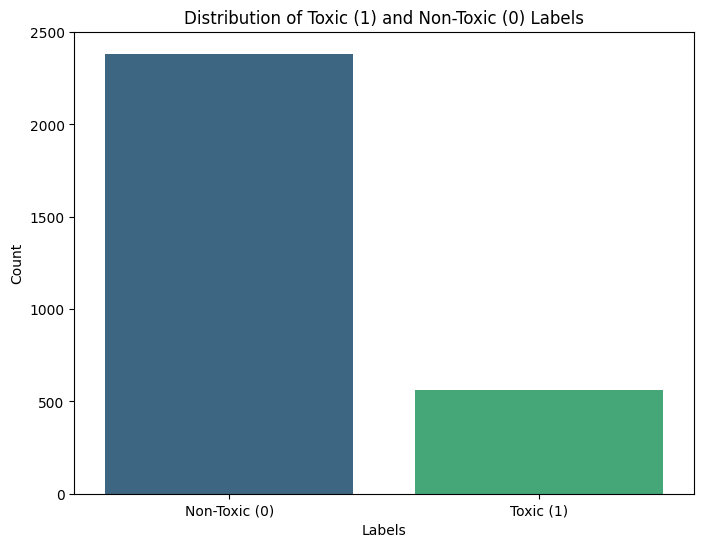

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
sns.countplot(x=labels, palette="viridis")

plt.title("Distribution of Toxic (1) and Non-Toxic (0) Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-Toxic (0)", "Toxic (1)"])

plt.show()

In [8]:
# If on GPU, do as below
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GPT2

In [ ]:
# Set to the GPT2Tokenizer and set lower case to True
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
# Set the padding to 'left' or 'right'?
# Remember we want to use the last token's embedding to represent the entire sentence
tokenizer.padding_side = 'left'

In [ ]:
def print_rand_sentence():
    '''Displays the tokens and respective IDs of a random text sample'''
    index = random.randint(0, len(text)-1)
    print(text[index])
    table = np.array([tokenizer.tokenize(text[index]),
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
    print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

this suck
╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ this     │        5661 │
├──────────┼─────────────┤
│ Ġsuck    │       10110 │
╘══════════╧═════════════╛


In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  # Use the tokenizer and the encode_plus methods to return the right data we'll need
  # Set max_length = 32 and return_tokens = 'pt'
  # Set other fields to the appropriate booleans needed
  return tokenizer.encode_plus(
      input_text,
      max_length = 32,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
  )


for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids'])
    attention_masks.append(encoding_dict['attention_mask'])


# Gather all the torch_id, attention masks, and labels
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
def print_rand_sentence_encoding():
    '''Displays tokens, token IDs and attention mask of a random text sample'''
    index = random.randint(0, len(text) - 1)
    tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
    print(tokens)
    token_ids = [i.numpy() for i in token_id[index]]
    attention = [i.numpy() for i in attention_masks[index]]
    table = np.array([tokens, token_ids, attention]).T
    print(
        tabulate(
            table,
            headers = ['Tokens', 'Token IDs', 'Attention Mask'],
            tablefmt = 'fancy_grid')
    )

print_rand_sentence_encoding()

['<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', 'dan', 'uc', 'd', 'hide']
╒═══════════════╤═════════════╤══════════════════╕
│ Tokens        │   Token IDs │   Attention Mask │
╞═══════════════╪═════════════╪══════════════════╡
│ <|endoftext|> │       50256 │                0 │
├───────────────┼─────────────┼──────────────────┤
│ <|endoftext|> │       50256 │                0 │
├───────────────┼─────────────┼──────────────────┤
│ <|endoftext|> │       50256 │                0 │
├───────────────┼─────────────┼──────────────────┤
│ <|endoftext|> │       50256 │       

In [ ]:
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 32

# Indices of the train and validation splits stratified by labels
# Use train_test_split
train_idx, val_idx = train_test_split(np.arange(len(labels)), test_size = val_ratio, shuffle = True, stratify = labels)

# Train and validation sets
# Set to TensorDataset
train_set = TensorDataset(token_id[train_idx], attention_masks[train_idx], labels[train_idx])

val_set = TensorDataset(token_id[val_idx], attention_masks[val_idx], labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(batch_size = batch_size, dataset = train_set, shuffle = True)

validation_dataloader = DataLoader(batch_size = batch_size, dataset = val_set, shuffle = True)

In [ ]:
# Load the GPT2 model
# Do not ouput the attentions and all hidden states

config = GPT2Config.from_pretrained('gpt2', output_attensions=False, output_hidden_states=False)

# Set to 'gpt2' (the smallest GPT2 which is 120 M parameters)
# Use the config above and set other labels as needed
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config = config)

# Set the pad token id to the eos token id
model.config.pad_token_id = tokenizer.eos_token_id

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5
# See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 5e-5,
    eps = 1e-08
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = model.to(device)

# Recommended number of epochs: See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 3

In [ ]:
# Print all the layers of this GPT2 model and the number of parameters per layer
# If this is False, fine tune just the classifier layer and leave all other GPT2 parameters alone
# If this is True, fine tune everything
fine_tune = True

total_parameters=0
for name, param in model.named_parameters():
    print(f"Layer: {name} | Parameters: {param.numel()}")
    total_parameters += param.numel()


# Turn off gradients using the above
if not fine_tune:
    for name, param in model.named_parameters():
        if 'score' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True
else:
    for name, param in model.named_parameters():
        param.requires_grad = True
print(total_parameters)
assert(total_parameters == 124441344)

Layer: transformer.wte.weight | Parameters: 38597376
Layer: transformer.wpe.weight | Parameters: 786432
Layer: transformer.h.0.ln_1.weight | Parameters: 768
Layer: transformer.h.0.ln_1.bias | Parameters: 768
Layer: transformer.h.0.attn.c_attn.weight | Parameters: 1769472
Layer: transformer.h.0.attn.c_attn.bias | Parameters: 2304
Layer: transformer.h.0.attn.c_proj.weight | Parameters: 589824
Layer: transformer.h.0.attn.c_proj.bias | Parameters: 768
Layer: transformer.h.0.ln_2.weight | Parameters: 768
Layer: transformer.h.0.ln_2.bias | Parameters: 768
Layer: transformer.h.0.mlp.c_fc.weight | Parameters: 2359296
Layer: transformer.h.0.mlp.c_fc.bias | Parameters: 3072
Layer: transformer.h.0.mlp.c_proj.weight | Parameters: 2359296
Layer: transformer.h.0.mlp.c_proj.bias | Parameters: 768
Layer: transformer.h.1.ln_1.weight | Parameters: 768
Layer: transformer.h.1.ln_1.bias | Parameters: 768
Layer: transformer.h.1.attn.c_attn.weight | Parameters: 1769472
Layer: transformer.h.1.attn.c_attn.bias

In [ ]:
# Use torchmetrics to set up accuracy, recall, precision, and auroc
accuracy = Accuracy(task="binary")
recall = Recall(task="binary")
precision = Precision(task="binary")
auroc = AUROC(task="binary")

In [ ]:
# Main training / validation loop
for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        # Put each element of batch onto the device
        batch = tuple(t.to(device) for t in batch)

        # Unpack the batch
        b_input_ids, b_input_mask, b_labels = batch

        # Set gradients to zero
        optimizer.zero_grad()

        # Forward pass
        train_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        # Backward pass
        train_output.loss.backward()
        optimizer.step()

        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)

        # Unpack the batch
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
          # Forward pass
            eval_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Calculate validation metrics
        labels = b_labels.cpu()
        predicted_labels = torch.argmax(eval_output.logits, dim=1).cpu()

        val_accuracy.append(accuracy(predicted_labels, labels))
        val_recall.append(recall(predicted_labels, labels))
        val_precision.append(precision(predicted_labels, labels))
        val_auroc.append(auroc(predicted_labels, labels))

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)))
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)))
    print('\t - Validation AUROC: {:.4f}\n'.format(sum(val_auroc)/len(val_auroc)))

Epoch:  33%|███▎      | 1/3 [00:17<00:35, 17.70s/it]


	 - Train loss: 0.4728
	 - Validation Accuracy: 0.8974
	 - Validation Precision: 0.7734
	 - Validation Recall: 0.7334
	 - Validation AUROC: 0.8364



Epoch:  67%|██████▋   | 2/3 [00:34<00:17, 17.43s/it]


	 - Train loss: 0.2587
	 - Validation Accuracy: 0.9047
	 - Validation Precision: 0.7034
	 - Validation Recall: 0.7975
	 - Validation AUROC: 0.8621



Epoch: 100%|██████████| 3/3 [00:51<00:00, 17.23s/it]


	 - Train loss: 0.2072
	 - Validation Accuracy: 0.9154
	 - Validation Precision: 0.7048
	 - Validation Recall: 0.7995
	 - Validation AUROC: 0.8686



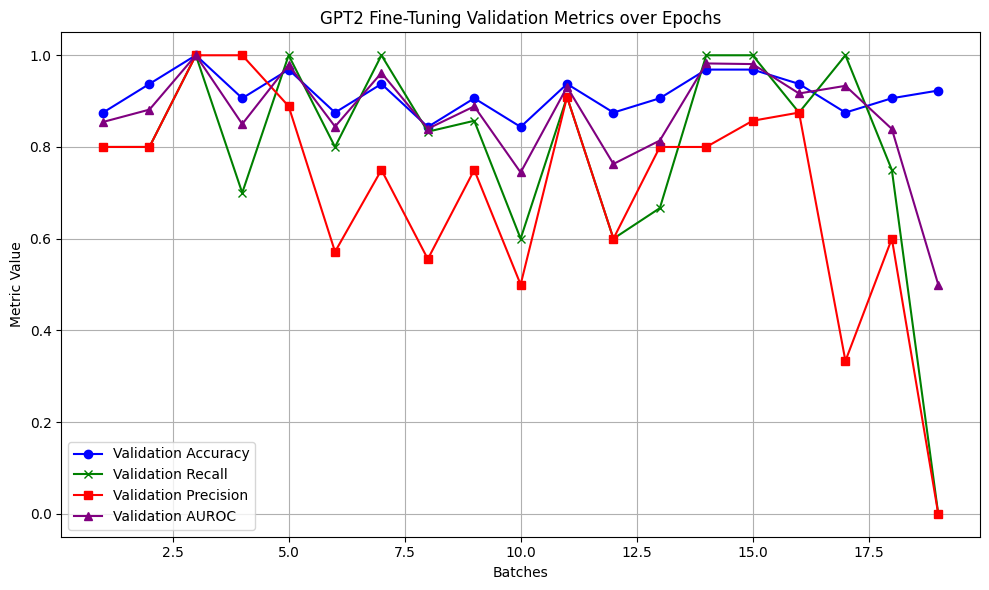

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(val_accuracy) + 1)

plt.figure(figsize=(10, 6))

# Plot each metric
plt.plot(epochs, val_accuracy, label="Validation Accuracy", color='b', marker='o')
plt.plot(epochs, val_recall, label="Validation Recall", color='g', marker='x')
plt.plot(epochs, val_precision, label="Validation Precision", color='r', marker='s')
plt.plot(epochs, val_auroc, label="Validation AUROC", color='purple', marker='^')

# Add labels and title
plt.xlabel('Batches')
plt.ylabel('Metric Value')
plt.title('GPT2 Fine-Tuning Validation Metrics over Epochs')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
new_sentence = 'unbelievable how shit some people in this game are.	'

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
    output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Toxic' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Not Toxic'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  unbelievable how shit some people in this game are.	
Predicted Class:  Toxic


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


**GPT Without Fine-Tuning**

Epoch 1:
- Train loss: 1.2015
- Validation Accuracy: 0.7435
- Validation Precision: 0.2391
- Validation Recall: 0.1460
- Validation AUROC: 0.5150

Epoch 2:
- Train loss: 0.6408
- Validation Accuracy: 0.8010
- Validation Precision: 0.0526
- Validation Recall: 0.0175
- Validation AUROC: 0.4716

Epoch 3:
- Train loss: 0.6099
- Validation Accuracy: 0.7923
- Validation Precision: 0.0526
- Validation Recall: 0.0088
- Validation AUROC: 0.4966

Correct Identification:

Input Sentence:  unbelievable how shit some people in this game are.
Predicted Class:  Toxic

**GPT With Fine-Tuning**

Epoch 1:
- Train loss: 0.4851
- Validation Accuracy: 0.8947
- Validation Precision: 0.7043
- Validation Recall: 0.7514
- Validation AUROC: 0.8406

Epoch 2:
- Train loss: 0.2705
- Validation Accuracy: 0.9146
- Validation Precision: 0.7342
- Validation Recall: 0.8857
- Validation AUROC: 0.9035

Epoch 3:
- Train loss: 0.2291
- Validation Accuracy: 0.9260
- Validation Precision: 0.7614
- Validation Recall: 0.9103
- Validation AUROC: 0.9199


Correct Identification:

Input Sentence:  unbelievable how shit some people in this game are.
Predicted Class:  Toxic

# BERT

In [ ]:
# Get the bert-base-uncased tokenizer and set lower case to True
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
def print_rand_sentence():
    '''Displays the tokens and respective IDs of a random text sample'''
    index = random.randint(0, len(text)-1)
    table = np.array([tokenizer.tokenize(text[index]),
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
    print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ o        │        1051 │
├──────────┼─────────────┤
│ ga       │       11721 │
├──────────┼─────────────┤
│ ##val    │       10175 │
├──────────┼─────────────┤
│ ##las    │        8523 │
├──────────┼─────────────┤
│ you      │        2017 │
├──────────┼─────────────┤
│ should   │        2323 │
├──────────┼─────────────┤
│ be       │        2022 │
├──────────┼─────────────┤
│ able     │        2583 │
├──────────┼─────────────┤
│ to       │        2000 │
├──────────┼─────────────┤
│ ##a      │        2050 │
╘══════════╧═════════════╛


In [ ]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=32,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )


for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids'])
    attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [ ]:
def print_rand_sentence_encoding():
    '''Displays tokens, token IDs and attention mask of a random text sample'''
    index = random.randint(0, len(text) - 1)
    tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
    token_ids = [i.numpy() for i in token_id[index]]
    attention = [i.numpy() for i in attention_masks[index]]
    table = np.array([tokens, token_ids, attention]).T
    print(
        tabulate(
            table,
            headers = ['Tokens', 'Token IDs', 'Attention Mask'],
            tablefmt = 'fancy_grid')
    )

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ lu       │       11320 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##l      │        2140 │                1 │
├──────────┼─────────────┼──────────────────┤
│ lu       │       11320 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##l      │        2140 │                1 │
├──────────┼─────────────┼──────────────────┤
│ lu       │       11320 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##l      │        2140 │                1 │
├──────────┼─────────────┼──────────────────┤
│ lu       │       11320 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##l      │        2140 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [SEP]    │         102 │        

In [ ]:
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 32

# Indices of the train and validation splits stratified by labels
train_idx, val_idx =  train_test_split(
    np.arange(len(labels)),
    test_size=val_ratio,
    stratify=labels
)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], attention_masks[train_idx], labels[train_idx])

val_set = TensorDataset(token_id[val_idx], attention_masks[val_idx], labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(train_set, sampler=RandomSampler(train_set), batch_size=batch_size)

validation_dataloader = DataLoader(val_set, sampler=SequentialSampler(val_set), batch_size=batch_size)

In [ ]:
# Define a LoRA Layer which has A, B and alpha parameters
class LoRALayer(torch.nn.Module):
  def __init__(self, in_dim, out_dim, rank, alpha):
    super().__init__()
    # Initialize A to be a parameter matrix of dimension in_dim by rank
    self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
    # Initialize all the elements of A via kaiming_uniform with a equal to sqrt(5)
    torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
    # Initialize B to be a zero parameter matrix of the appropriate dimensions
    self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
    self.alpha = alpha

  def forward(self, x):
    # Pass x through the LoRA layer and return the new x
    x = self.alpha * (x @ self.A @ self.B)
    return x

# Define a class LoRALinear which has a linear layer and a LoRA layer on top
class LoRALinear(torch.nn.Module):
  def __init__(self, linear, rank, alpha):
    super().__init__()
    self.linear = linear
    self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

  def forward(self, x):
    # Pass x through the linear layer and also the lora layer
    return self.linear(x) + self.lora(x)

def lora_linear_replace(model, rank, alpha):
  # Use model.named_children to go through all layers and if the layer is Linear replace that layer with LoRALinear
  for name, module in model.named_children():
    # If the module is linear, replace the module in the model with a LoRA layer
    if isinstance(module, torch.nn.Linear):
      # Replace the Linear layer with LoRALinear
      setattr(model, name, LoRALinear(module, rank, alpha))
    else:
      # Alterntively, recursively apply the same function to child modules so that other Linear layers get replaced
      lora_linear_replace(module, rank, alpha)

In [ ]:
# Load the BertForSequenceClassification model
# Do not ouput the attentions and all hidden states
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, output_attentions=False, output_hidden_states=False)

# Turn off all gradients of the model to start
for param in model.parameters():
    param.requires_grad = False

# Set to True if LORA is used; if False, fine_tune flag will be used to decide if you fine tune the entire model or just parts
use_lora  = False
# If this is False, turn off gradients
fine_tune = True
# Set total_parameters to 0; this will count the number of parameters in each case
total_parameters = 0

if use_lora:
  # Use the lora_linear to attach a LoRA layer to each linear later of the original BERT model
  lora_linear_replace(model, rank=8, alpha=8)
  # Get the total number of parameters with gradients
  total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
else:
  # If fine_tune is off, turn off gradients for all layers other than classifier
  if not fine_tune:
    # Turn off all gradients; count just the 'classifier' layer which is the only one that has gradients
    for name, param in model.named_parameters():
      if "classifier" in name:
        param.requires_grad = True
        total_parameters += param.numel()
      else:
        param.requires_grad = False
  else:
    # Turn off all gradients except for classifier
    for param in model.parameters():
      param.requires_grad = True
      total_parameters += param.numel()

print(total_parameters)

if use_lora:
  assert(total_parameters == 1345552)
else:
  if fine_tune:
    assert(total_parameters == 109483778)
  else:
    assert(total_parameters == 1538)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


109483778


In [ ]:
import platform

# Pick the system you have and select GPU if you can
if platform.system() == 'Darwin':
    device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
elif platform.system() == 'Linux':
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
else:
    device = torch.device('cpu')
print(device)

cuda


In [ ]:
_ = model.to(device)

# Recommended number of epochs: See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2

In [ ]:
# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5
# See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 5e-5,
    eps = 1e-08
)

In [ ]:
# Use torchmetrics to set up accuracy, recall, precision, and auroc
accuracy = Accuracy(task="binary", num_classes=2).to(device)
recall = Recall(task="binary").to(device)
precision = Precision(task="binary").to(device)
auroc = AUROC(task="binary").to(device)

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
# Main training / validation loop
import tqdm
for _ in tqdm.tqdm(trange(epochs, desc = 'Epoch')):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in tqdm.tqdm(enumerate(train_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the batch
        b_input_ids, b_input_mask, b_labels = batch

        # Set the gradients to zero
        optimizer.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        # Backward pass
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_auroc = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
            eval_output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Calculate validation metrics
        logits = eval_output.logits
        labels = b_labels
        predicted_labels = torch.argmax(logits, dim=1)

        val_accuracy.append(accuracy(predicted_labels, labels).item())
        val_recall.append(recall(predicted_labels, labels).item())
        val_precision.append(precision(predicted_labels, labels).item())
        val_auroc.append(auroc(logits.softmax(dim=1)[:, 1], labels).item())

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)))
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)))
    print('\t - Validation AUROC: {:.4f}\n'.format(sum(val_auroc)/len(val_auroc)))

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1it [00:00,  4.08it/s]

2it [00:00,  4.52it/s]

3it [00:00,  4.52it/s]

4it [00:00,  4.80it/s]

5it [00:01,  4.93it/s]

6it [00:01,  5.05it/s]

7it [00:01,  5.06it/s]

8it [00:01,  5.06it/s]

9it [00:01,  5.07it/s]

10it [00:02,  5.10it/s]

11it [00:02,  5.12it/s]

12it [00:02,  5.12it/s]

13it [00:02,  5.15it/s]

14it [00:02,  5.13it/s]

15it [00:03,  5.15it/s]

16it [00:03,  5.16it/s]

17it [00:03,  5.17it/s]

18it [00:03,  5.18it/s]

19it [00:03,  5.20it/s]

20it [00:03,  5.17it/s]

21it [00:04,  5.13it/s]

22it [00:04,  5.14it/s]

23it [00:04,  5.14it/s]

24it [00:04,  5.15it/s]

25it [00:04,  5.16it/s]

26it [00:05,  5.41it/s]

27it [00:05,  5.24it/s]

28it [00:05,  5.11it/s]

29it [00:05,  5.14it/s]

30it [00:05,  5.14it/s]

31it [00:06,  5.16it/s]

32it [00:06,  5.15it/s]

33it [00:06,  5.08it/s]

34it [00:06,  5.05it/s]

35it [00:06,  4.95it/s]

36it [00:07,  4.95it/s]

37it [00:07,  4.98it/s]

38it [00:07,  4.92it/s]




	 - Train loss: 0.3011
	 - Validation Accuracy: 0.9038
	 - Validation Precision: 0.7737
	 - Validation Recall: 0.7197
	 - Validation AUROC: 0.9251





0it [00:00, ?it/s]

1it [00:00,  5.33it/s]

2it [00:00,  5.24it/s]

3it [00:00,  5.21it/s]

4it [00:00,  5.21it/s]

5it [00:00,  5.16it/s]

6it [00:01,  5.12it/s]

7it [00:01,  5.11it/s]

8it [00:01,  5.41it/s]

9it [00:01,  5.22it/s]

10it [00:01,  5.19it/s]

11it [00:02,  5.15it/s]

12it [00:02,  5.14it/s]

13it [00:02,  5.13it/s]

14it [00:02,  5.12it/s]

15it [00:02,  5.14it/s]

16it [00:03,  5.12it/s]

17it [00:03,  5.11it/s]

18it [00:03,  5.11it/s]

19it [00:03,  5.11it/s]

20it [00:03,  5.11it/s]

21it [00:04,  5.11it/s]

22it [00:04,  5.08it/s]

23it [00:04,  5.06it/s]

24it [00:04,  5.05it/s]

25it [00:04,  5.07it/s]

26it [00:05,  5.08it/s]

27it [00:05,  5.09it/s]

28it [00:05,  5.09it/s]

29it [00:05,  5.08it/s]

30it [00:05,  5.09it/s]

31it [00:06,  5.09it/s]

32it [00:06,  5.06it/s]

33it [00:06,  5.01it/s]

34it [00:06,  5.01it/s]

35it [00:06,  5.02it/s]

36it [00:07,  5.02it/s]

37it [00:07,  5.02it/s]

38it [00:07,  5.03it/s]

39it [00:07,  5.03it/s]

40it [00:07,


	 - Train loss: 0.1804
	 - Validation Accuracy: 0.8956
	 - Validation Precision: 0.6977
	 - Validation Recall: 0.8552
	 - Validation AUROC: 0.9417



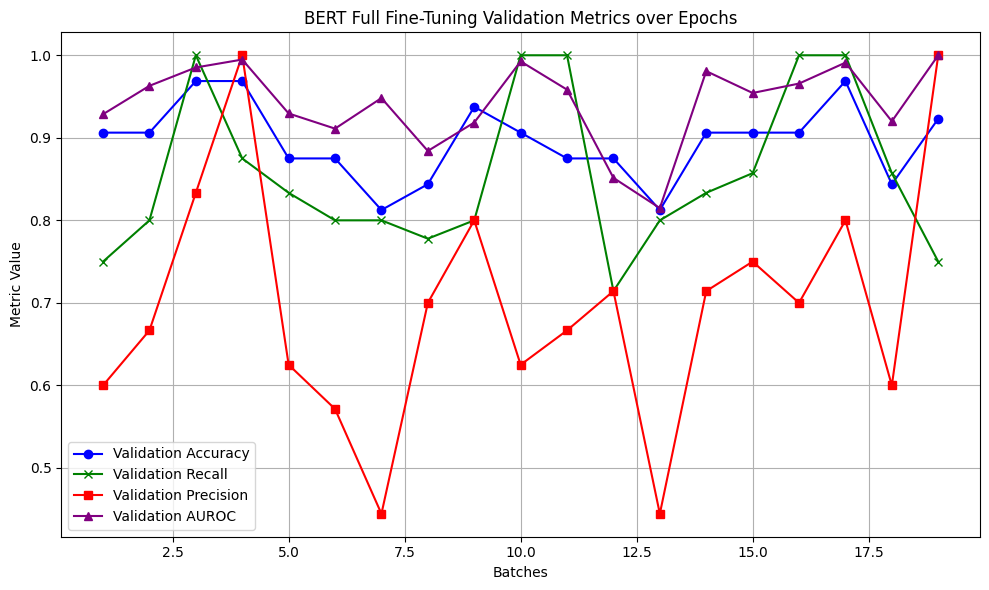

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(val_accuracy) + 1)

plt.figure(figsize=(10, 6))

# Plot each metric
plt.plot(epochs, val_accuracy, label="Validation Accuracy", color='b', marker='o')
plt.plot(epochs, val_recall, label="Validation Recall", color='g', marker='x')
plt.plot(epochs, val_precision, label="Validation Precision", color='r', marker='s')
plt.plot(epochs, val_auroc, label="Validation AUROC", color='purple', marker='^')

# Add labels and title
plt.xlabel('Batches')
plt.ylabel('Metric Value')
plt.title('BERT Full Fine-Tuning Validation Metrics over Epochs')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
new_sentence = 'unbelievable how shit some people in this game are.	'

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
    output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Toxic' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Not Toxic'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  unbelievable how shit some people in this game are.	
Predicted Class:  Toxic


**BERT No Fine-Tuning**

Epoch 1:
- Train loss: 0.5957
- Validation Accuracy: 0.8062
- Validation Precision: 0.0000
- Validation Recall: 0.0000
- Validation AUROC: 0.6411

Epoch 2:
- Train loss: 0.4895
- Validation Accuracy: 0.8062
- Validation Precision: 0.0000
- Validation Recall: 0.0000
- Validation AUROC: 0.6519

Incorrect Identification

Input Sentence:  unbelievable how shit some people in this game are.
Predicted Class:  Not Toxic

**BERT Full Fine-Tuning**

Epoch 1:
- Train loss: 0.3613
- Validation Accuracy: 0.9122
- Validation Precision: 0.7321
- Validation Recall: 0.8720
- Validation AUROC: 0.9425

Epoch 2:
- Train loss: 0.1981
- Validation Accuracy: 0.9089
- Validation Precision: 0.7179
- Validation Recall: 0.8458
- Validation AUROC: 0.9511

Correct Identification

Input Sentence:  unbelievable how shit some people in this game are.
Predicted Class:  Toxic

**BERT LoRA Fine-Tuning**

Epoch 1:
- Train loss: 0.3156
- Validation Accuracy: 0.9089
- Validation Precision: 0.7179
- Validation Recall: 0.8768
- Validation AUROC: 0.9479

Epoch 2:
- Train loss: 0.1944
- Validation Accuracy: 0.9073
- Validation Precision: 0.7036
- Validation Recall: 0.8922
- Validation AUROC: 0.9616

Correct Identification
Input Sentence:  unbelievable how shit some people in this game are.
Predicted Class:  Toxic